# Qual figure
### Show examples from 75%, 50% and 25% dice score

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
from statannotations.Annotator import Annotator
import sys
sys.path.append('/home/local/VANDERBILT/litz/github/MASILab/lobe_seg')
from luna16_preprocess import get_kfolds
from dataloader import test_dataloader
sys.path.append('/home/local/VANDERBILT/litz/github/MASILab/thoraxtools/func/vis')
from vis import vis
import nibabel as nib
from skimage.transform import resize

### lobe seg model setup

In [146]:
sys.path.append('/home/local/VANDERBILT/litz/github/MASILab/')
from dataloader import test_dataloader
from models import unet512
import yaml
import random
import torch
from monai.utils import set_determinism
from monai.metrics import DiceMetric

import os
import sys
from tqdm import tqdm
import torch
import SimpleITK as sitk
import gc
import psutil
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
from monai.transforms import (
    Compose,
    AsDiscrete,
    AddChannel,
    EnsureType,
    EnsureTyped,
    AsDiscreted,
    LoadImaged,
    Orientationd,
    AddChanneld,
    Spacingd,
    ScaleIntensityRanged,
    EnsureTyped,
    CropForegroundd,
    Invertd,
    Compose,
    Spacingd,
    Resized,
    Orientationd,
)
from monai.data import DataLoader, Dataset
from pandas import DataFrame
import numpy as np
from postprocess import get_largest_cc, nearest_label_filling, lungmask_filling
sys.path.append("/home/local/VANDERBILT/litz/github/MASILab/thoraxtools/func")
import vis.paral_clip_overlay_mask as overlay


def load_config(config_name, config_dir):
    with open(os.path.join(config_dir, config_name)) as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
    return config

CONFIG_DIR = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/configs"
config_id = "test"
config = load_config(f"Config_{config_id}.YAML", CONFIG_DIR)
set_determinism(seed=config["random_seed"])
random.seed(config["random_seed"])
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device("cuda:0")
model = unet512(6).to(device)
model_path = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0511cval/fold1/0511cval_best_model.pth"
test_metric = DiceMetric(include_background=False, reduction="none")

def run_inference(image, pixdim, output_shape, axcodes, config, config_id, device, model, model_path, test_metric):
    test_loader = test_dataloader(config, image)
    device = torch.device(config["device"])
    model.load_state_dict(torch.load(model_path))
    model.eval()
    test_metric.reset()
    post_pred_transforms = Compose([
        EnsureTyped(keys=["label", "pred"]),
        AsDiscreted(keys="pred", argmax=True, to_onehot=6),
        AsDiscreted(keys="label", to_onehot=6),
        Orientationd(keys=["pred"], axcodes=axcodes),
        Spacingd(keys=["pred"], pixdim=pixdim, mode="nearest"), 
        Resized(keys=["pred"], spatial_size=output_shape, mode="nearest"),
    ])
    measure_transforms = Compose([EnsureType(), AddChannel(), AsDiscrete(to_onehot=6)])
    image_paths = []
    with torch.no_grad():
        for test_data in test_loader:
            test_inputs, image_path = (
                test_data["image"].to(device),
                # test_data["label"][0, 0, :, :, :].detach().cpu().numpy(),
                test_data["image_path"][0],
            )
            image_paths.append(image_path)
            test_data["pred"] = sliding_window_inference(test_inputs, config["crop_shape"], 4, model)
            test_data["pred"] = test_data["pred"].detach().cpu()
            test_data = [post_pred_transforms(i) for i in decollate_batch(test_data)]
            test_data = test_data[0]
            
            # fuse with lung mask using nearest label filling
            pred = torch.argmax(test_data["pred"], dim=0)
            pred = lungmask_filling(get_largest_cc(pred), image_path)
            test_data["pred"] = measure_transforms(pred)
            
            test_metric(y_pred=[test_data["pred"]], y=[test_data["label"]])
            metric = test_metric.aggregate()
            print(metric)
            
            label_map = torch.argmax(test_data["pred"], dim=0).numpy()

            # transform to image space orientation
            # print(f"before transform {postprocess.shape}")
            # postprocess = vis_transforms(postprocess)[0]
            # las_pred = las_transforms(pred)[0]
            # lps_pred = lps_transforms(pred)[0]
            # print(f"after transform {postprocess.shape}")
            
    return label_map


### some vis tools

In [27]:
def vis_overlay_slices(img, label, xyz, orientation="LAS", label_orientation="LAS", cmap="turbo", clip_range=(-1024, 600), mask_range=(0,5)):
    label = np.where(label == 0, np.nan, label)
    img_clip_sag, img_clip_cor, img_clip_ax = vis.clip_LAS(img, xyz) if orientation == "LAS" else vis.clip_LPS(img, xyz)
    label_clip_sag, label_clip_cor, label_clip_ax = vis.clip_LAS(label, xyz) if label_orientation == "LAS" else vis.clip_LPS(label,
                                                                                                               xyz)
    if len(clip_range) > 0:
        vmin = clip_range[0]
        vmax = clip_range[1]
    else:
        vmax = np.max(img)
        vmin = np.min(img)
    f, ax = plt.subplots(1, 3, figsize=(15, 15))

    sag = ax[0].imshow(img_clip_sag, interpolation='bilinear', cmap="gray", alpha=1.0, vmin=clip_range[0],
                       vmax=clip_range[1])
    ax[0].imshow(label_clip_sag, interpolation='none', cmap=cmap, alpha=0.5, vmin=mask_range[0], vmax=mask_range[1])
    ax[1].imshow(img_clip_cor, interpolation='bilinear', cmap="gray", alpha=1.0, vmin=clip_range[0], vmax=clip_range[1])
    ax[1].imshow(label_clip_cor, interpolation='none', cmap=cmap, alpha=0.5, vmin=mask_range[0], vmax=mask_range[1])
    ax[2].imshow(img_clip_ax, interpolation='bilinear', cmap="gray", alpha=1.0, vmin=clip_range[0], vmax=clip_range[1])
    ax[2].imshow(label_clip_ax, interpolation='none', cmap=cmap, alpha=0.5, vmin=mask_range[0], vmax=mask_range[1])


## Find representative examples

In [3]:
metric_dir = "/home/local/VANDERBILT/litz/data/luna16/metrics"
johof_folds = glob.glob(os.path.join(metric_dir, "johof_norm*"))
lsm_folds = glob.glob(os.path.join(metric_dir, "lsm_*"))
model_dir = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0418cv_luna16"
# model_dir = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0506cval"
al_model_dir = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0511cval"
kfolds_path = "/home/local/VANDERBILT/litz/data/luna16/5fold_qa.csv"
# kfolds_path = "/home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/5folds.csv"
fold_paths = get_kfolds(kfolds_path)
unet3d_folds = []
for d, _, _ in os.walk(model_dir):
    unet3d_folds.extend(glob.glob(os.path.join(d, "dataset_rand_test.csv")))
al_folds = []
for d, _, _ in os.walk(al_model_dir):
    al_folds.extend(glob.glob(os.path.join(d, "dataset_rand_test.csv")))

johof_folds = sorted(johof_folds)
lsm_folds = sorted(lsm_folds)
unet3d_folds = sorted(unet3d_folds)
al_folds = sorted(al_folds)

In [4]:
al_folds

['/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0511cval/fold1/dataset_rand_test.csv',
 '/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0511cval/fold2/dataset_rand_test.csv',
 '/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0511cval/fold3/dataset_rand_test.csv',
 '/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0511cval/fold4/dataset_rand_test.csv',
 '/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0511cval/fold5/dataset_rand_test.csv']

In [14]:
# parse metric csv's into dataframes
johof_df = pd.read_csv(johof_folds[0])
johof_df["fold"] = int(johof_folds[0][-5])
# johof_df["path"] = fold_paths
for i, johof_fold in enumerate(johof_folds):
    if i > 0:
        johof_fold_df = pd.read_csv(johof_fold)
        johof_fold_df["fold"] = int(johof_fold[-5])
        johof_df = pd.concat([johof_df, johof_fold_df], ignore_index=True)
# johof_df.drop(columns=['Unnamed: 0'], inplace=True)

lsm_df = pd.read_csv(lsm_folds[0])
lsm_df["fold"] = int(lsm_folds[0][-5])
for i, lsm_fold in enumerate(lsm_folds):
    if i > 0:
        lsm_fold_df = pd.read_csv(lsm_fold)
        lsm_fold_df["fold"] = int(lsm_fold[-5])
        lsm_df = pd.concat([lsm_df, lsm_fold_df], ignore_index=True)
lsm_df.drop(columns=['Unnamed: 0'], inplace=True)

unet_df = pd.read_csv(unet3d_folds[0])
unet_df["fold"] = int(unet3d_folds[0][-23])
for i, unet3d_fold in enumerate(unet3d_folds):
    if i > 0:
        unet_fold_df = pd.read_csv(unet3d_fold)
        unet_fold_df["fold"] = int(unet3d_fold[-23])
        unet_df = pd.concat([unet_df, unet_fold_df], ignore_index=True)
unet_df.drop(columns=['Unnamed: 0'], inplace=True)

al_df = pd.read_csv(al_folds[0])
al_df["fold"] = int(al_folds[0][-23])
for i, al_fold in enumerate(al_folds):
    if i > 0:
        al_fold_df = pd.read_csv(al_fold)
        al_fold_df["fold"] = int(al_fold[-23])
        al_df = pd.concat([al_df, al_fold_df], ignore_index=True)
al_df.drop(columns=['Unnamed: 0'], inplace=True)

# convert index to column to identify subjects
johof_df['id'] = johof_df.index
lsm_df['id'] = lsm_df.index
unet_df['id'] = unet_df.index
al_df['id'] = al_df.index

In [31]:
al_75

0         1         2         3         4  \
9   0.976741  0.977775  0.977007  0.961066  0.975610   
11  0.912279  0.922551  0.978349  0.956887  0.979387   
13  0.983719  0.980279  0.978176  0.961301  0.978583   
24  0.971848  0.963337  0.961412  0.952260  0.977137   
27  0.977361  0.966702  0.966289  0.953048  0.968920   
29  0.931457  0.939538  0.972354  0.946654  0.977815   
39  0.953840  0.957980  0.975733  0.949323  0.975463   
42  0.972706  0.978628  0.976135  0.963295  0.978710   
44  0.981190  0.979762  0.980322  0.961498  0.981424   
56  0.974571  0.979523  0.979340  0.965317  0.977237   
57  0.976887  0.974205  0.974053  0.945238  0.976980   
59  0.973744  0.976422  0.979249  0.955577  0.981938   
71  0.977332  0.975378  0.973115  0.959706  0.978716   

                                                                                                       input_path  \
9   /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000667time20170526.nii.gz   
11  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000650time20120530.nii.gz   
13  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000707time20130524.nii.gz   
24  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000486time20171002.nii.gz   
27  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000677time20180705.nii.gz   
29  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000771time20170821.nii.gz   
39  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000616time20170421.nii.gz   
42  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000648time20170515.nii.gz   
44  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000905time20171215.nii.gz   
56  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000797time20170906.nii.gz   
57  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000894time20150211.nii.gz   
59  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000847time20171018.nii.gz   
71  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000735time20170719.nii.gz   

    fold  id  
9      1   9  
11     1  11  
13     1  13  
24     2  24  
27     2  27  
29     2  29  
39     3  39  
42     3  42  
44     3  44  
56     4  56  
57     4  57  
59     4  59  
71     5  71

In [18]:
al_50

0         1         2         3         4  \
10  0.978553  0.973214  0.967318  0.938605  0.973191   
12  0.977556  0.976143  0.972152  0.931020  0.975658   
14  0.974332  0.970440  0.956426  0.934146  0.964161   
25  0.968235  0.951412  0.969741  0.941009  0.966040   
26  0.969147  0.939418  0.974972  0.940415  0.969767   
41  0.961583  0.976901  0.966094  0.934162  0.974467   
72  0.972982  0.969204  0.961220  0.937658  0.972373   
73  0.916146  0.894923  0.965009  0.944907  0.953961   
74  0.978931  0.977038  0.925101  0.930052  0.955465   
76  0.985303  0.982931  0.941341  0.925048  0.962126   

                                                                                                       input_path  \
10  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00001110time20180201.nii.gz   
12  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000965time20180129.nii.gz   
14  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000801time20170908.nii.gz   
25  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000900time20171208.nii.gz   
26  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00001090time20180702.nii.gz   
41  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00001109time20180629.nii.gz   
72  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000838time20160730.nii.gz   
73  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00001104time20180216.nii.gz   
74  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00001034time20180711.nii.gz   
76  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00001022time20180531.nii.gz   

    fold  id  
10     1  10  
12     1  12  
14     1  14  
25     2  25  
26     2  26  
41     3  41  
72     5  72  
73     5  73  
74     5  74  
76     5  76

In [17]:
pd.set_option('display.max_colwidth', None)
# get active learning case that is above 75th percentile performance
score_75 = np.percentile(al_df['3'], 75)
print(f"75th percentil score for RML: {score_75}")
al_75 = al_df[(al_df['3']>=score_75) & (al_df['input_path'].str.contains('time'))]
print(al_75.iloc[0]['3'], al_75.iloc[0]['input_path'])

# between 75th and 50th percentile
score_50 = np.percentile(al_df['3'], 50)
print(f"50th percentil score for RML: {score_50}")
al_50 = al_df[(al_df['3']>=score_50) & (al_df['3']<score_75) & (al_df['input_path'].str.contains('time'))]
print(al_50.iloc[0]['3'], al_50.iloc[0]['input_path'])

# below 25th percentile
score_25 = np.percentile(al_df['3'], 25)
print(f"25th percentile score for RML: {score_25}")
al_25 = al_df[(al_df['3']<=score_25) & (al_df['input_path'].str.contains('time'))]
print(al_25.iloc[0]['3'], al_25.iloc[0]['input_path'])
al_25

75th percentil score for RML: 0.9452378
0.961066 /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000667time20170526.nii.gz
50th percentil score for RML: 0.9223483
0.9386048 /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00001110time20180201.nii.gz
25th percentile score for RML: 0.8707241
0.5322894 /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00001033time20181022.nii.gz


0         1         2         3         4  \
28  0.979243  0.978380  0.940047  0.532289  0.915335   
40  0.968017  0.962320  0.873146  0.526891  0.969967   
43  0.978454  0.974563  0.956825  0.797539  0.915452   
54  0.982934  0.960392  0.917909  0.858986  0.923054   
75  0.953747  0.913110  0.951838  0.870724  0.944766   

                                                                                                       input_path  \
28  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00001033time20181022.nii.gz   
40  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000541time20180628.nii.gz   
43  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000045time20170920.nii.gz   
54  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000663time20170525.nii.gz   
75  /home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000864time20180205.nii.gz   

    fold  id  
28     2  28  
40     3  40  
43     3  43  
54     4  54  
75     5  75

In [90]:
images = [
    # "00000707time20130524", # 75%
    # "00001034time20180711", # 50%
    "00001033time20181022" # 25%
    # "00000541time20180628", # 10%
]
# images = ["1.3.6.1.4.1.14519.5.2.1.6279.6001.151669338315069779994664893123"]
# raw_dir = "/home/local/VANDERBILT/litz/data/imagevu/nifti/train_preproc"
raw_dir = "/home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/"
johof_dir = "/home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/johof/"
lsm_dir = "/home/local/VANDERBILT/litz/data/imagevu/lobe/lvlsetsegCC/"
truth_dir = "/home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/label_nifti/"
raw_paths = [os.path.join(raw_dir, f"{i}.nii.gz") for i in images]
johof_paths = [os.path.join(johof_dir, f"johof_{i}.nii.gz") for i in images]
lsm_paths = [os.path.join(lsm_dir, f"lvlsetseg_{i}.nii.gz") for i in images]
truth_paths = [os.path.join(truth_dir, f"{i}_lvlsetseg.nii.gz") for i in images]


In [170]:
from lungmask import mask
import SimpleITK as sitk

unets = []

for i in range(len(images)):
    # get johof and lsm
    raw_nii = nib.load(raw_paths[i])
    spatial_size = raw_nii.shape
    pixdim = raw_nii.header.get_zooms()
    axcodes = nib.orientations.aff2axcodes(raw_nii.affine)
    axcodes = ''.join(axcodes)
    
    # get model inference
    unet_img = run_inference([raw_paths[i]], pixdim, spatial_size, axcodes, config, config_id, device, model, model_path, test_metric)
    unets.append(unet_img)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 281.43it/s]


tensor([[0.9903, 0.9879, 0.9826, 0.9654, 0.9852]])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 119.46it/s]


tensor([[0.9896, 0.9843, 0.9715, 0.9502, 0.9839]])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 365.20it/s]


tensor([[0.9873, 0.9868, 0.9772, 0.8733, 0.9675]])


In [176]:
raws = []
johofs = []
lsms = []
truths = []

for i in range(len(images)):
    raw_img = nib.load(raw_paths[i]).get_fdata()
    johof_img = nib.load(johof_paths[i]).get_fdata()
    lsm_img = nib.load(lsm_paths[i]).get_fdata()
    truth_img = nib.load(truth_paths[i]).get_fdata()
    raws.append(raw_img)
    johofs.append(johof_img)
    lsms.append(lsm_img)
    truths.append(truth_img)

In [159]:
# swap axes of sitk images
# lungmasks = [np.swapaxes(img, 0,2) for img in lungmasks]


[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]


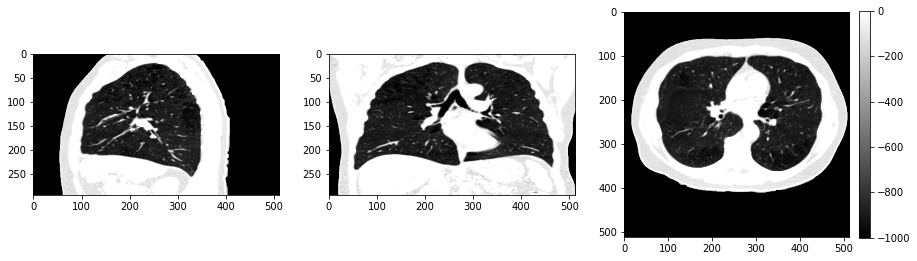

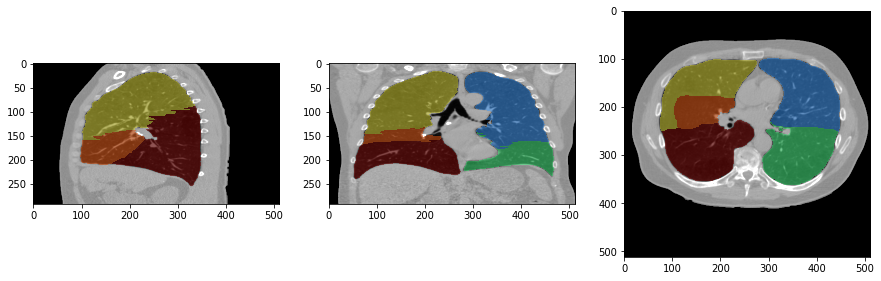

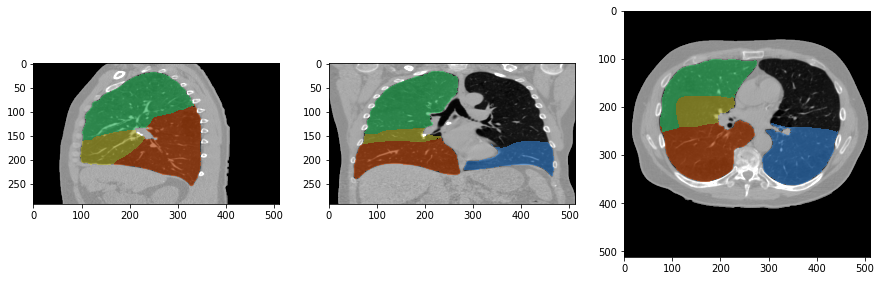

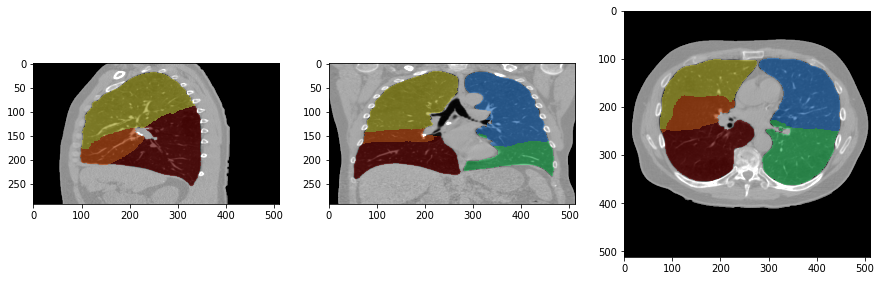

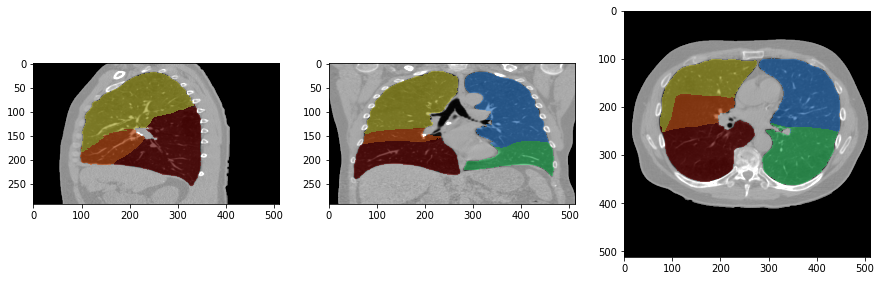

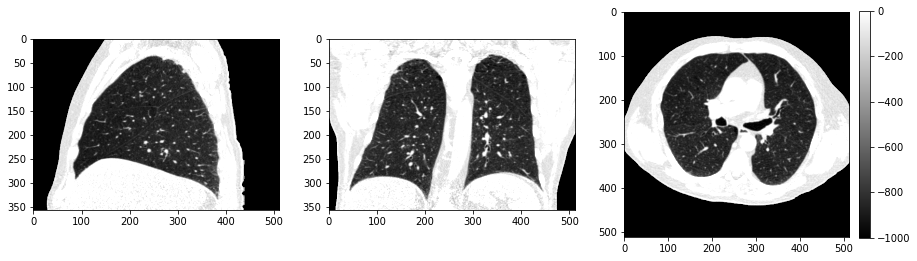

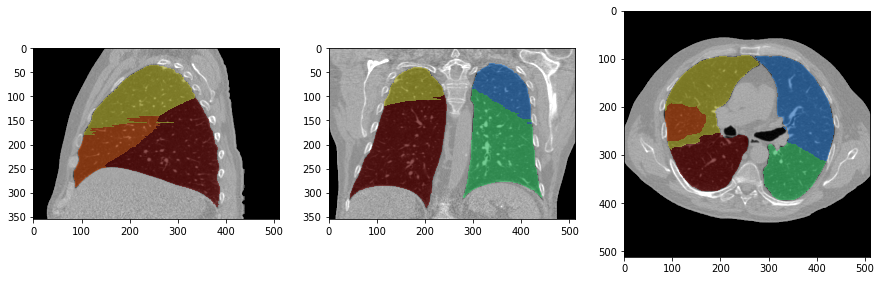

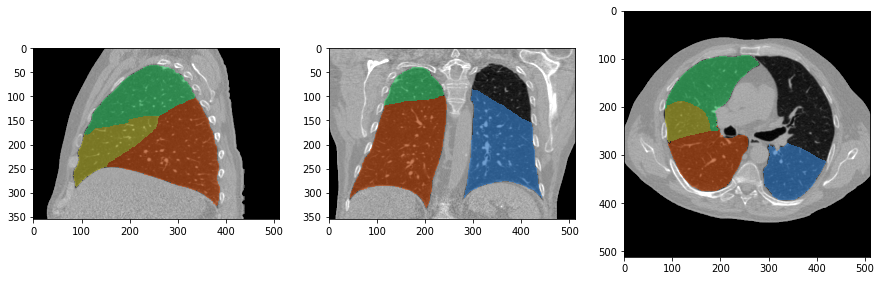

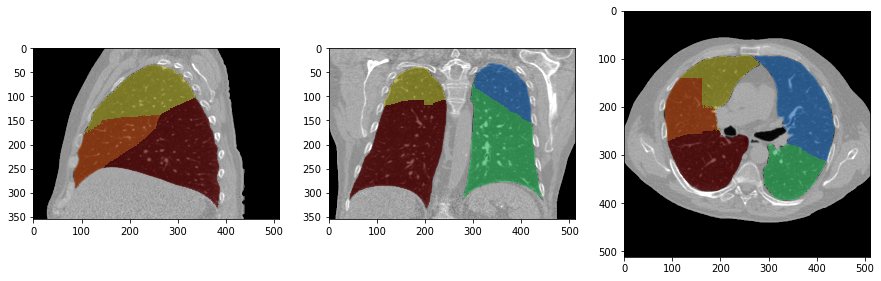

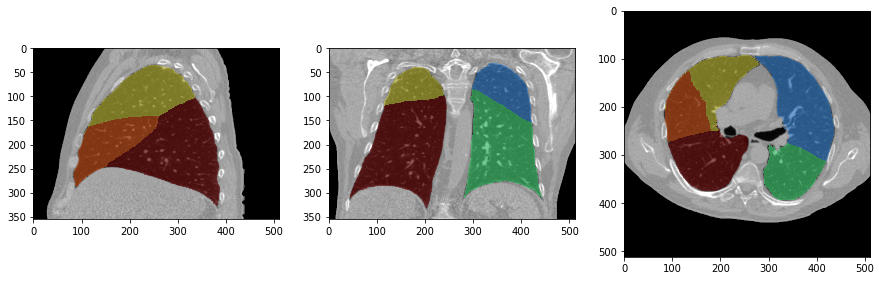

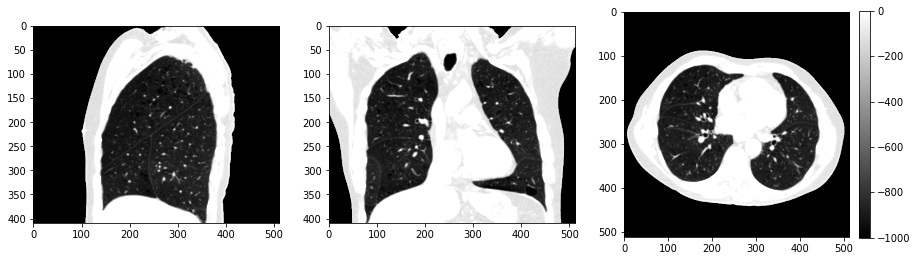

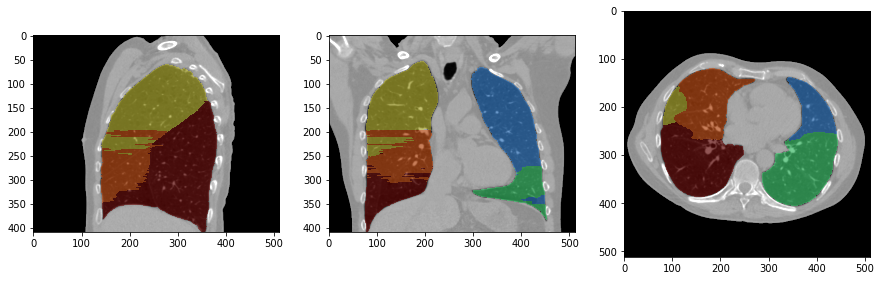

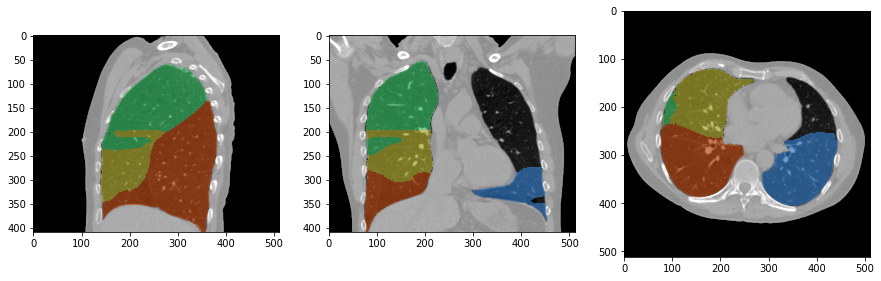

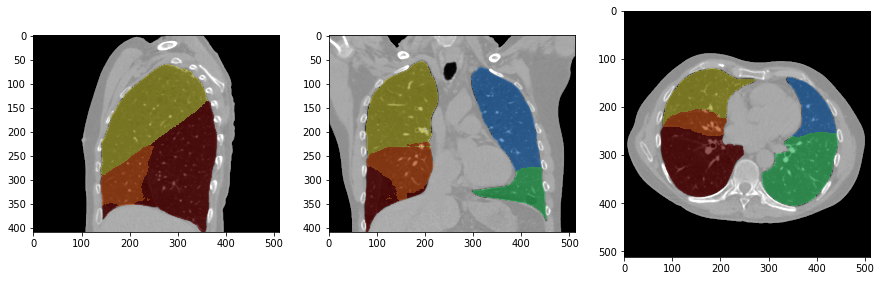

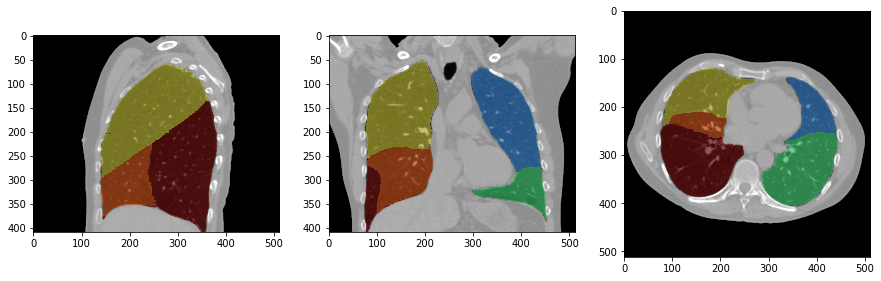

In [160]:
fig_dir = '/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/tmp/figures'
xyzs = [(75, (200,285,150)), (50, (140, 200, 200)), (25, (125, 281, 161))]
# xyzs = [(75, (110,285,150)), (50, (140, 200, 200))]
for i, (p, xyz) in enumerate(xyzs):
    vis.vis_slices(raws[i], xyz, orientation="LAS", clip_range=[-1000,0])
    # vis_overlay_slices(raws[i], lungmasks[i], xyz, cmap="turbo")
    vis.vis_overlay_slices(raws[i], johofs[i], xyz, orientation="LAS", cmap="turbo")
    # plt.savefig(os.path.join(fig_dir, f"{i}_johof.png"))
    vis.vis_overlay_slices(raws[i], lsms[i], xyz, orientation="LAS", cmap="turbo")
    # plt.savefig(os.path.join(fig_dir, f"{i}_lsm.png"))
    vis.vis_overlay_slices(raws[i], unets[i], xyz, orientation="LAS", cmap="turbo")
    # plt.savefig(os.path.join(fig_dir, f"{i}_unet.png"))
    vis.vis_overlay_slices(raws[i], truths[i], xyz, orientation="LAS", cmap="turbo")
    # plt.savefig(os.path.join(fig_dir, f"{i}_truth.png"))
    

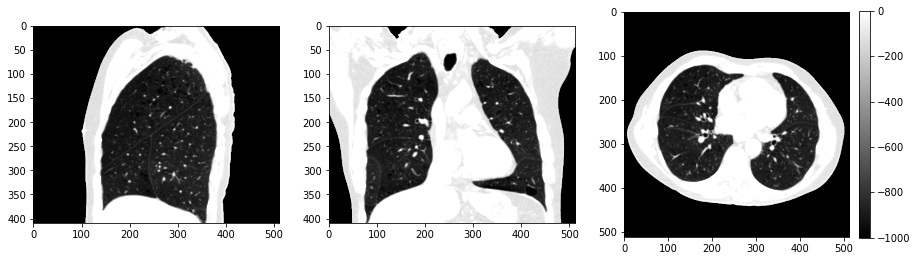

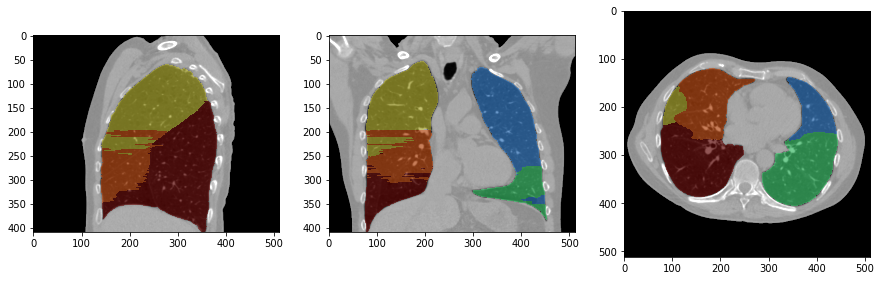

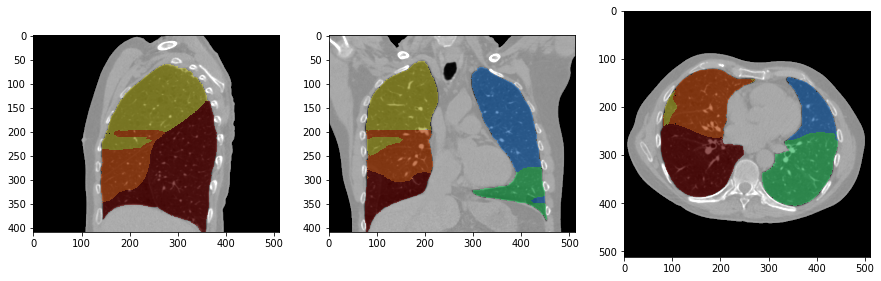

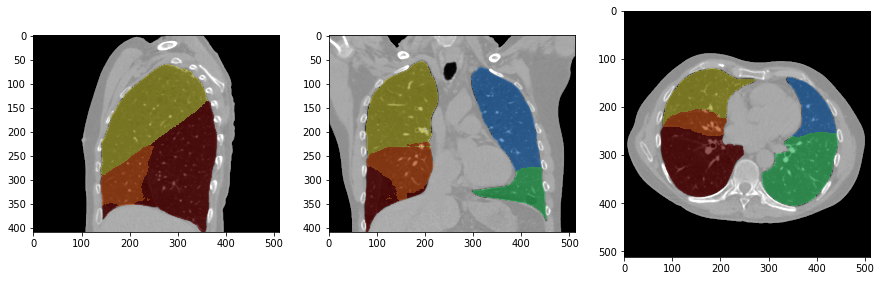

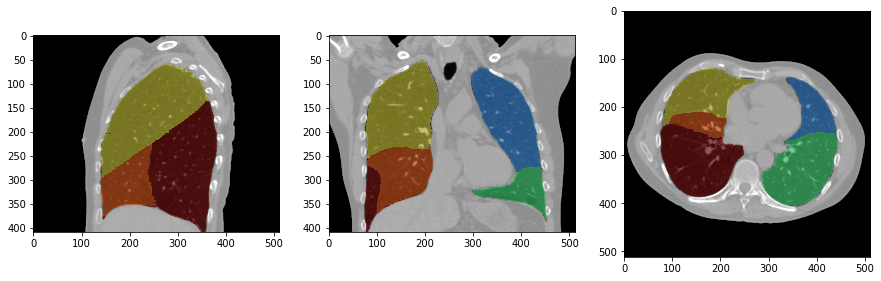

In [126]:
xyz = (125, 281, 161)
vis.vis_slices(raws[2], xyz, orientation="LAS", clip_range=[-1000,0])
# vis_overlay_slices(raws[i], lungmasks[i], xyz, cmap="turbo")
vis.vis_overlay_slices(raws[2], johofs[2], xyz, orientation="LAS", cmap="turbo")
# plt.savefig(os.path.join(fig_dir, f"{i}_johof.png"))
vis.vis_overlay_slices(raws[2], lsms[2], xyz, orientation="LAS", cmap="turbo")
# plt.savefig(os.path.join(fig_dir, f"{i}_lsm.png"))
vis.vis_overlay_slices(raws[2], unets[2], xyz, orientation="LAS", cmap="turbo")
# plt.savefig(os.path.join(fig_dir, f"{i}_unet.png"))
vis.vis_overlay_slices(raws[2], truths[2], xyz, orientation="LAS", cmap="turbo")
# plt.savefig(os.path.join(fig_dir, f"{i}_truth.png"))

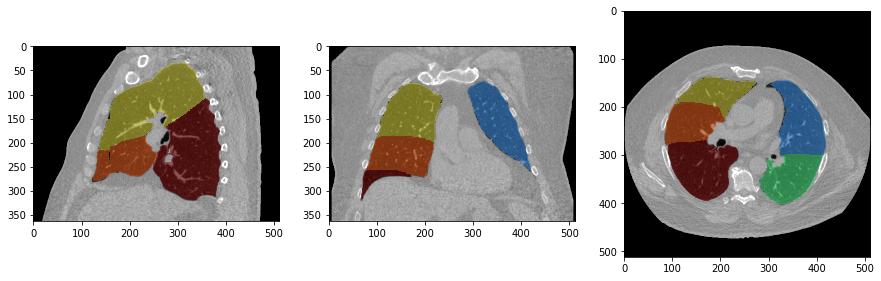

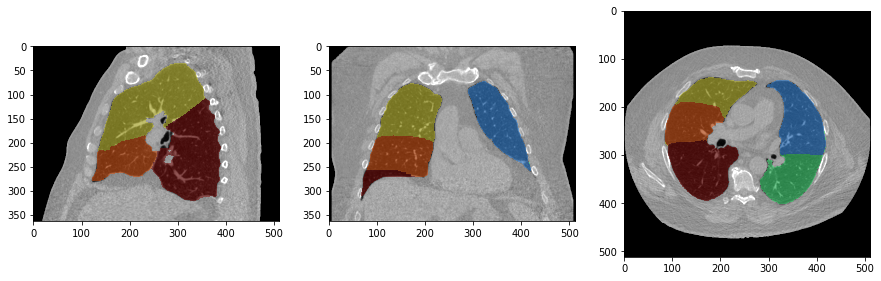

In [23]:
from scipy import ndimage
from lungmask import mask

vis.vis_overlay_slices(raws[1], unets[1], (200, 305, 170), cmap="turbo")

def lungmask_filling(cc, lungmask):
    """
    Motivation: Since finding CCs is a reductionary operation, previously labeled voxels may loose labels. The nearest lable filling algorithm label voxels in the lung field that were labeled before cc reduction. implementation:
    1. find signed distance transform of each lobe, where more negative is inside the segmentation and more positive is outside
    2. subtract the lung mask from the binary post-cc image to find voxels that lost labels
    3. for each such voxel, assign it the label that corresponds to the smallest dt value across all lobes
    4. find cc of filled segmentation - this will remove voxels in the background that were labeled
    """
    dst_no_labels = np.zeros((5, *cc.shape))
    no_label = np.where(lungmask, 1, 0) - np.where(cc, 1, 0)
    for i in range(5):
        label = i+1
        binary = np.where(cc==label, 1, 0)
        inv_binary = np.where(cc==label, 0, 1)
        dst = -ndimage.distance_transform_cdt(binary) + ndimage.distance_transform_cdt(inv_binary)
        dst_no_labels[i, :,:,:] = np.where(no_label, dst, 0)

    nearest = np.argmin(dst_no_labels, axis=0)
    nearest = np.where(no_label, nearest + 1, 0)
    filled = cc + nearest
    return get_largest_cc(filled)

proc_unet = nearest_label_filling(lungmasks[1], unets[1])
vis.vis_overlay_slices(raws[1], proc_unet, (200, 305, 170), cmap="turbo")

In [127]:
def vis_overlay_slices(img, label, xyz, orientation="LAS", cmap="turbo", clip_range=(-1024, 600), mask_range=(0,5)):
    label = np.where(label == 0, np.nan, label)
    img_clip_sag, img_clip_cor, img_clip_ax = vis.clip_LAS(img, xyz) if orientation == "LAS" else vis.clip_LPS(img, xyz)
    label_clip_sag, label_clip_cor, label_clip_ax = vis.clip_LAS(label, xyz) if orientation == "LAS" else vis.clip_LPS(label,
                                                                                                               xyz)
    if len(clip_range) > 0:
        vmin = clip_range[0]
        vmax = clip_range[1]
    else:
        vmax = np.max(img)
        vmin = np.min(img)
    f, ax = plt.subplots(1, 3, figsize=(15, 15))

    sag = ax[0].imshow(img_clip_sag, interpolation='bilinear', cmap="gray", alpha=1.0, vmin=clip_range[0],
                       vmax=clip_range[1])
    ax[0].imshow(label_clip_sag, interpolation='none', cmap=cmap, alpha=0.5, vmin=mask_range[0], vmax=mask_range[1])
    ax[1].imshow(img_clip_cor, interpolation='bilinear', cmap="gray", alpha=1.0, vmin=clip_range[0], vmax=clip_range[1])
    ax[1].imshow(label_clip_cor, interpolation='none', cmap=cmap, alpha=0.5, vmin=mask_range[0], vmax=mask_range[1])
    ax[2].imshow(img_clip_ax, interpolation='bilinear', cmap="gray", alpha=1.0, vmin=clip_range[0], vmax=clip_range[1])
    ax[2].imshow(label_clip_ax, interpolation='none', cmap=cmap, alpha=0.5, vmin=mask_range[0], vmax=mask_range[1])
    for a in ax:
        a.axis('off')
        a.set_xticklabels([])
        a.set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)

### Final figures for qualitative result of good, bad, and ugly

In [189]:
# print(np.unique(johofs[0]))
# print(np.unique(lsms[0]))
raws[0].shape

(512, 512, 293)

In [199]:
# resize to 512x512x400
from monai.transforms import EnsureType, Resize, AddChannel, AsDiscrete
template_shape = (512, 512, 300)
resize_transforms = Compose([EnsureType(), AddChannel(), Resize(spatial_size=template_shape, mode="nearest")], AsDiscrete())
raw_resize_transforms = Compose([EnsureType(), AddChannel(), Resize(spatial_size=template_shape, mode="trilinear")])
for i in range(len(johofs)):
    # raws[i] = raw_resize_transforms(raws[i])[0]
    # johofs[i] = resize_transforms(johofs[i])[0]
    # lsms[i] = resize_transforms(lsms[i])[0]
    unets[i] = resize_transforms(unets[i])[0]
    # truths[i] = resize_transforms(truths[i])[0]




In [196]:
# print(np.unique(johofs[0]))
# print(np.unique(lsms[0]))
raws[0].shape

(512, 512, 300)

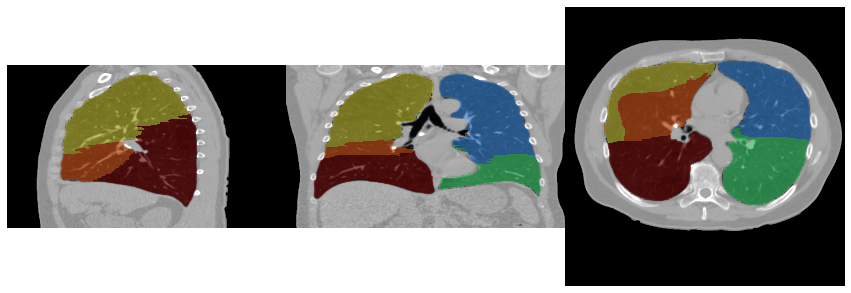

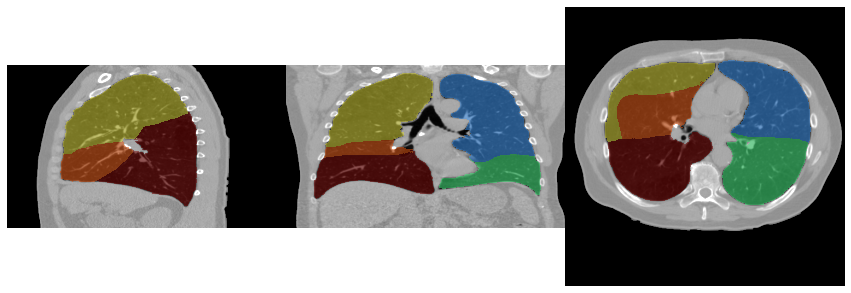

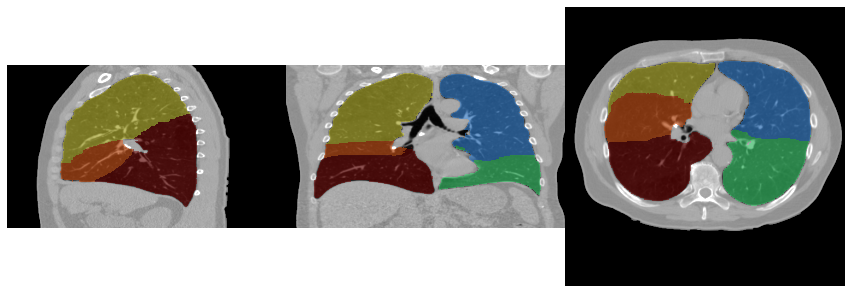

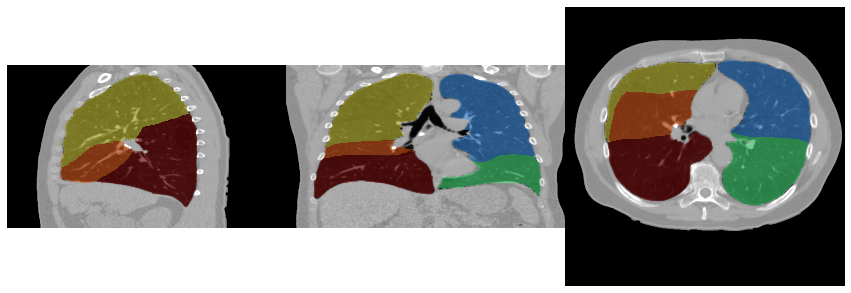

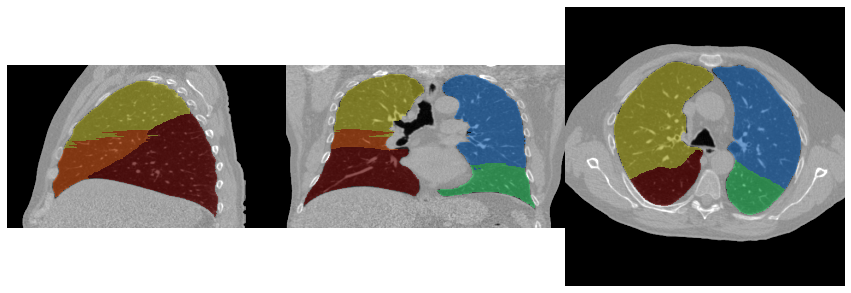

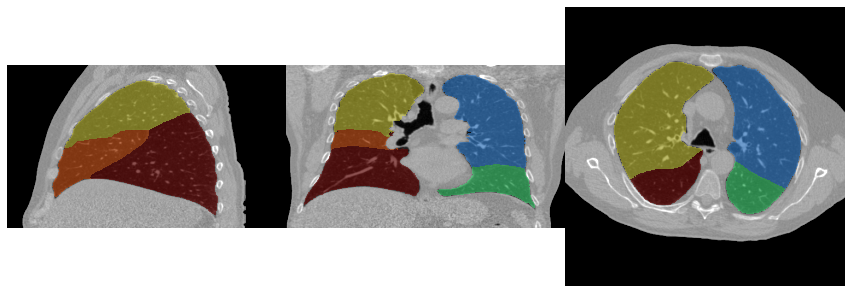

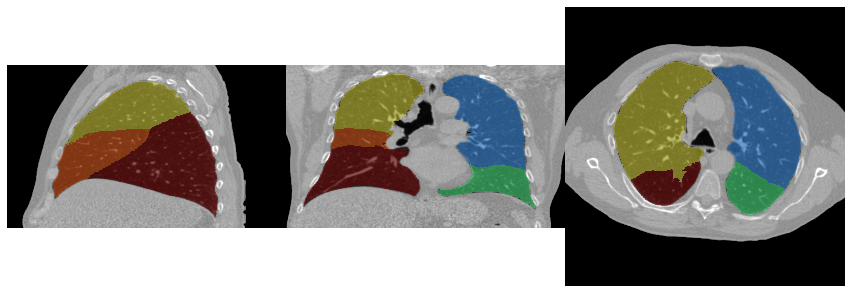

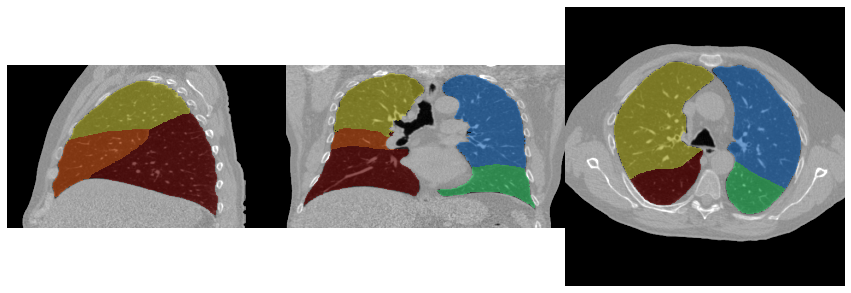

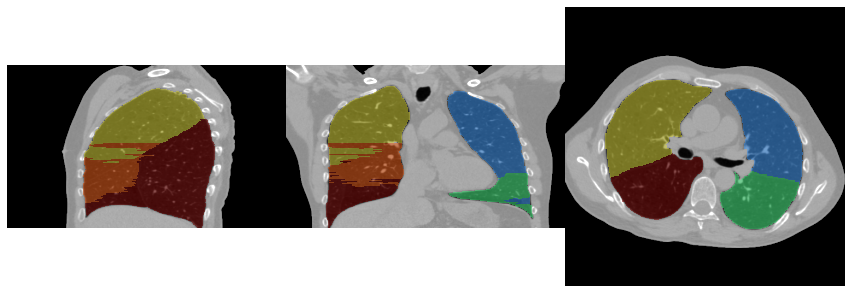

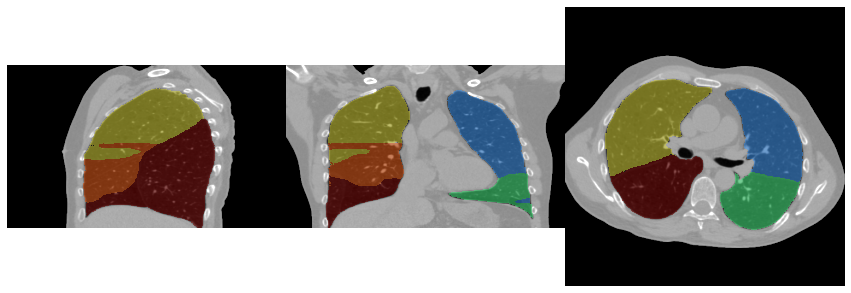

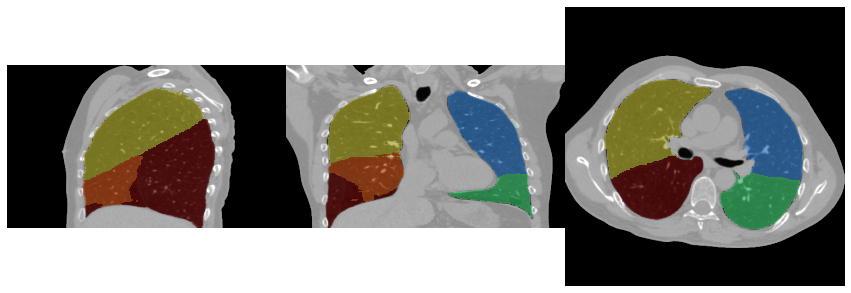

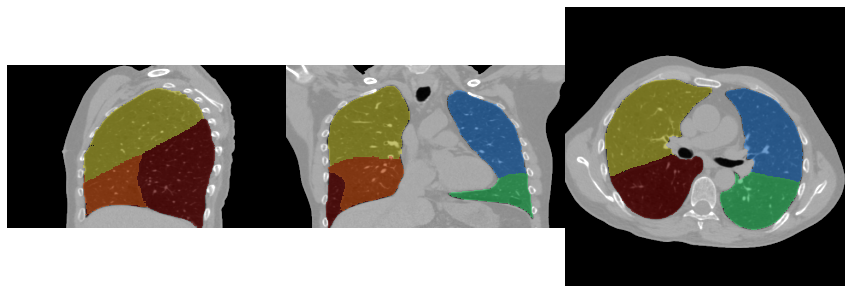

In [224]:
fig_dir = '/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/tmp/figures'
xyzs = [(75, (200,285,150)), (50, (140, 270, 200)), (25, (125, 281, 161))]
for i, (p, xyz) in enumerate(xyzs):
    # vis.vis_slices(raws[i], xyz, orientation="LAS", clip_range=[-1000,0])
    # vis_overlay_slices(raws[i], lungmasks[i], xyz, cmap="turbo")
    vis_overlay_slices(raws[i], johofs[i], xyz, orientation="LAS", cmap="turbo")
    plt.savefig(os.path.join(fig_dir, f"{p}_johof.png"))
    vis_overlay_slices(raws[i], lsms[i], xyz, orientation="LAS", cmap="turbo")
    plt.savefig(os.path.join(fig_dir, f"{p}_lsm.png"))
    vis_overlay_slices(raws[i], unets[i], xyz, orientation="LAS", cmap="turbo")
    plt.savefig(os.path.join(fig_dir, f"{p}_unet.png"))
    vis_overlay_slices(raws[i], truths[i], xyz, orientation="LAS", cmap="turbo")
    plt.savefig(os.path.join(fig_dir, f"{p}_truth.png"))

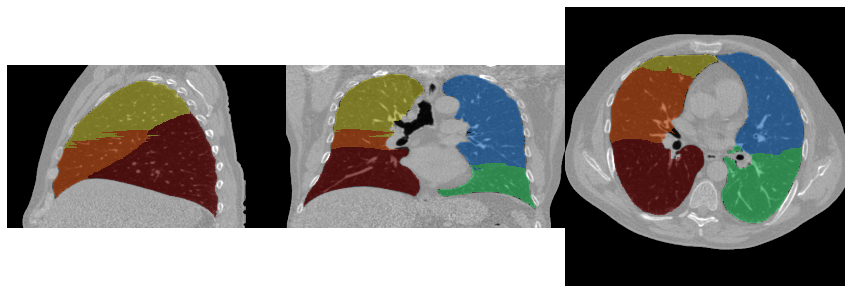

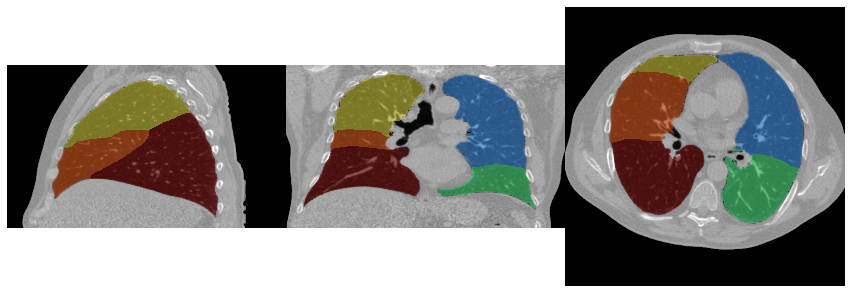

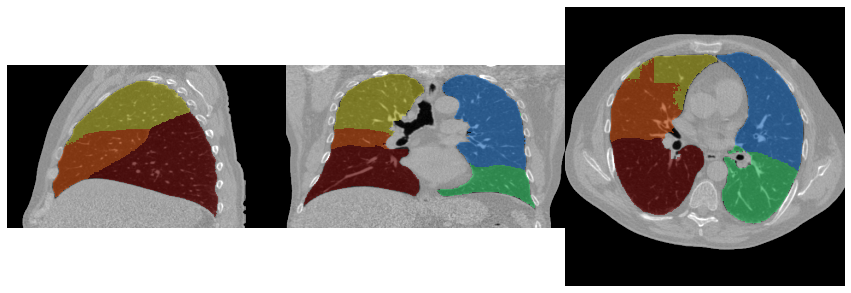

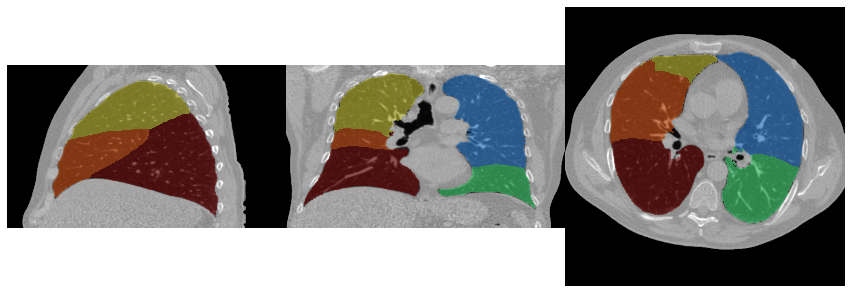

In [222]:
xyz = (140, 270, 150)
vis_overlay_slices(raws[1], johofs[1], xyz, orientation="LAS", cmap="turbo")
# plt.savefig(os.path.join(fig_dir, f"{i}_johof.png"))
vis_overlay_slices(raws[1], lsms[1], xyz, orientation="LAS", cmap="turbo")
# plt.savefig(os.path.join(fig_dir, f"{i}_lsm.png"))
vis_overlay_slices(raws[1], unets[1], xyz, orientation="LAS", cmap="turbo")
# plt.savefig(os.path.join(fig_dir, f"{i}_unet.png"))
vis_overlay_slices(raws[1], truths[1], xyz, orientation="LAS", cmap="turbo")